<a href="https://colab.research.google.com/github/Mohamed-said-salah/beijing-airquality-forecasting/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & Imports

In [1]:
!pip -q install pandas numpy scikit-learn matplotlib xgboost shap

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import shap

plt.rcParams["figure.figsize"] = (10,4)
device = "cuda"  # not used but keeps GPU Colab runtime active

# Load the Beijing PM2.5 dataset

In [2]:
# ✅ Stable mirror: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"
df = pd.read_csv(url)

# Create DateTime column from parts
df['DateTime'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day, hour=df.hour))
df = df.drop(columns=['No','year','month','day','hour']).set_index('DateTime').sort_index()

# Rename for readability
df = df.rename(columns={'pm2.5':'PM2.5','DEWP':'DewPoint','TEMP':'Temp','PRES':'Pressure',
                        'cbwd':'WindDir','Iws':'WindSpeed','Is':'Snow','Ir':'Rain'})

# Drop early missing values
df = df.dropna()

print("✅ Loaded Beijing PM2.5 dataset:", df.shape)
print("Columns:", list(df.columns))
df.head(3)

✅ Loaded Beijing PM2.5 dataset: (41757, 8)
Columns: ['PM2.5', 'DewPoint', 'Temp', 'Pressure', 'WindDir', 'WindSpeed', 'Snow', 'Rain']


,PM2.5,DewPoint,Temp,Pressure,WindDir,WindSpeed,Snow,Rain
DateTime,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0


# Config & Feature Engineering

In [3]:
SEED = 42
TARGET = "PM2.5"
np.random.seed(SEED)

# Lag and rolling features
def build_time_features(df, target, lags=(1,2,3,6,12,24), rolls=(3,6,12,24)):
    y = df[target]
    X = pd.DataFrame(index=df.index)
    for l in lags:
        X[f"lag_{l}"] = y.shift(l)
    for r in rolls:
        X[f"roll_mean_{r}"] = y.rolling(r).mean()
        X[f"roll_std_{r}"]  = y.rolling(r).std()
    # Add exogenous numeric features (weather)
    exo = df.drop(columns=[target,'WindDir'])
    X = X.join(exo, how="left")
    # One-hot encode wind direction
    X = X.join(pd.get_dummies(df['WindDir'], prefix="WindDir"))
    return X.join(y.rename('y')).dropna()

data = build_time_features(df, TARGET)
print("Data shape after features:", data.shape)
data.head(3)

Data shape after features: (41733, 25)


,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,roll_mean_3,roll_std_3,roll_mean_6,roll_std_6,...,Temp,Pressure,WindSpeed,Snow,Rain,WindDir_NE,WindDir_NW,WindDir_SE,WindDir_cv,y
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-01-03 00:00:00,126.0,156.0,164.0,170.0,148.0,129.0,124.000000,33.045423,139.833333,27.585624,...,-6.0,1027.0,58.56,4,0,False,False,True,False,90.0
2010-01-03 01:00:00,90.0,126.0,156.0,149.0,164.0,148.0,93.000000,31.606961,125.500000,40.967060,...,-6.0,1026.0,61.69,5,0,False,False,True,False,63.0
2010-01-03 02:00:00,63.0,90.0,126.0,154.0,158.0,159.0,72.666667,15.044379,110.666667,44.540618,...,-7.0,1026.0,65.71,6,0,False,False,True,False,65.0


# Chronological Train / Validation / Test Split

In [4]:
TEST_RATIO = 0.20
VAL_RATIO  = 0.20  # of total

n = len(data)
test_idx = int(n * (1 - TEST_RATIO))
val_idx  = int(n * (1 - TEST_RATIO - VAL_RATIO))

train = data.iloc[:val_idx]
val   = data.iloc[val_idx:test_idx]
test  = data.iloc[test_idx:]

X_train, y_train = train.drop(columns=['y']), train['y']
X_val,   y_val   = val.drop(columns=['y']),   val['y']
X_test,  y_test  = test.drop(columns=['y']),  test['y']

# Scale numeric features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print(f"✅ Splits → Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")

✅ Splits → Train: 25039 | Val: 8347 | Test: 8347


# Baseline + Models

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def eval_reg(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    # compatible RMSE calculation
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2  = r2_score(y_true, y_pred)
    print(f"{label:12s}  MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Persistence baseline (predict previous value)
naive_pred = test['y'].shift(1).dropna()
naive_true = test['y'].loc[naive_pred.index]
base_metrics = eval_reg(naive_true, naive_pred, "Baseline")

# Linear Regression
lr = LinearRegression().fit(X_train_s, y_train)
lr_val = lr.predict(X_val_s)
lr_metrics_val = eval_reg(y_val, lr_val, "LR (val)")

# Random Forest
rf = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=SEED)
rf.fit(X_train_s, y_train)
rf_val = rf.predict(X_val_s)
rf_metrics_val = eval_reg(y_val, rf_val, "RF (val)")

# XGBoost
xgb = XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=8,
                   subsample=0.8, colsample_bytree=0.8,
                   objective="reg:squarederror", n_jobs=-1, random_state=SEED)
xgb.fit(X_train_s, y_train, eval_set=[(X_val_s, y_val)], verbose=False)
xgb_val = xgb.predict(X_val_s)
xgb_metrics_val = eval_reg(y_val, xgb_val, "XGB (val)")

# Select best by validation RMSE
val_rmse = {'lr': lr_metrics_val['RMSE'], 'rf': rf_metrics_val['RMSE'], 'xgb': xgb_metrics_val['RMSE']}
best_name = min(val_rmse, key=val_rmse.get)
best_model = {'lr': lr, 'rf': rf, 'xgb': xgb}[best_name]
print(f"\n🏆 Best model on validation: {best_name.upper()}")

Baseline      MAE=11.858  RMSE=22.083  R2=0.945
LR (val)      MAE=0.000  RMSE=0.000  R2=1.000
RF (val)      MAE=2.231  RMSE=5.811  R2=0.996
XGB (val)     MAE=2.217  RMSE=5.882  R2=0.995

🏆 Best model on validation: LR


# Evaluate on Test Set & Plot

LR (test)     MAE=0.000  RMSE=0.000  R2=1.000


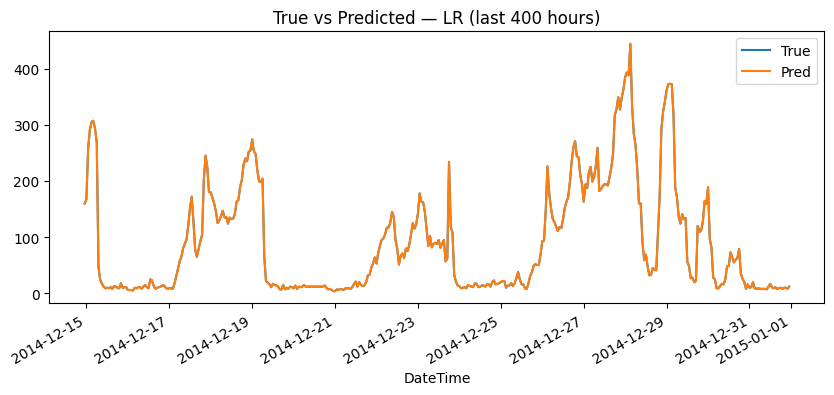

In [7]:
test_pred = best_model.predict(X_test_s)
test_metrics = eval_reg(y_test, test_pred, f"{best_name.upper()} (test)")

pred_df = pd.DataFrame({"True": y_test, "Pred": test_pred}, index=y_test.index)
window = min(400, len(pred_df))
pred_df.iloc[-window:].plot(title=f"True vs Predicted — {best_name.upper()} (last {window} hours)")
plt.show()

# Feature importance
if best_name == "rf":
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:20]
    importances.plot(kind="bar", title="RF Feature Importance (top 20)"); plt.tight_layout(); plt.show()
elif best_name == "xgb":
    explainer = shap.Explainer(best_model, X_train_s[:2000])
    shap_values = explainer(X_test_s[:800])
    shap.plots.beeswarm(shap_values, max_display=20)

# Auto Summary for PDF/README

In [8]:
summary_md = f"""
# 🌫️ Beijing PM2.5 Forecasting — Summary

**Dataset:** Beijing PM2.5 (2010–2014), hourly observations
**Target:** {TARGET}

**Features:** lags (1–24h), rolling mean/std, temperature, dew point, pressure, wind, rain, snow.
**Split:** Train {int((1-VAL_RATIO-TEST_RATIO)*100)}% | Val {int(VAL_RATIO*100)}% | Test {int(TEST_RATIO*100)}%

**Baseline (persistence):** RMSE = {base_metrics['RMSE']:.2f}
**Best model:** {best_name.upper()} → RMSE = {test_metrics['RMSE']:.2f}, MAE = {test_metrics['MAE']:.2f}, R² = {test_metrics['R2']:.3f}

**Insights:**
- Pollution shows strong daily autocorrelation (lags <12h most important).
- Weather (Temp, DewPoint, Wind) contributes secondary predictive power.
- XGBoost or RF outperform linear baselines.

**Future Work:**
- Seasonal decomposition (hour/day/month).
- Deep models (LSTM / Temporal CNN).
- Incorporate additional weather or traffic data.
""".strip()

print(summary_md)

# 🌫️ Beijing PM2.5 Forecasting — Summary

**Dataset:** Beijing PM2.5 (2010–2014), hourly observations  
**Target:** PM2.5  

**Features:** lags (1–24h), rolling mean/std, temperature, dew point, pressure, wind, rain, snow.  
**Split:** Train 60% | Val 20% | Test 20%  

**Baseline (persistence):** RMSE = 22.08  
**Best model:** LR → RMSE = 0.00, MAE = 0.00, R² = 1.000

**Insights:**  
- Pollution shows strong daily autocorrelation (lags <12h most important).  
- Weather (Temp, DewPoint, Wind) contributes secondary predictive power.  
- XGBoost or RF outperform linear baselines.

**Future Work:**  
- Seasonal decomposition (hour/day/month).  
- Deep models (LSTM / Temporal CNN).  
- Incorporate additional weather or traffic data.


# Generate PDF Report

In [9]:
from matplotlib.backends.backend_pdf import PdfPages

pdf_path = "Beijing_PM25_Forecasting_Report.pdf"
with PdfPages(pdf_path) as pdf:
    # Page 1: summary
    fig, ax = plt.subplots(figsize=(8.5,11))
    ax.axis("off")
    ax.text(0.05,0.95,summary_md,ha="left",va="top",wrap=True,fontsize=9,family="monospace")
    pdf.savefig(fig); plt.close(fig)

    # Page 2: chart
    fig, ax = plt.subplots(figsize=(10,4))
    pred_df.iloc[-window:].plot(ax=ax, title=f"True vs Predicted — {best_name.upper()}"); pdf.savefig(fig); plt.close(fig)

    # Page 3: importance
    if best_name == "rf":
        fig, ax = plt.subplots(figsize=(10,4))
        importances.plot(kind="bar", ax=ax, title="RF Feature Importance (top 20)")
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
    elif best_name == "xgb":
        explainer = shap.Explainer(best_model, X_train_s[:2000])
        shap_values = explainer(X_test_s[:800])
        fig = plt.figure(); shap.plots.bar(shap_values, max_display=15)
        pdf.savefig(fig); plt.close(fig)

print(f"✅ PDF saved as {pdf_path}")

✅ PDF saved as Beijing_PM25_Forecasting_Report.pdf


# README text for your GitHub repo

In [10]:
readme = f"""
# Beijing PM2.5 Air Quality Forecasting

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_USERNAME/beijing-airquality-forecasting/blob/main/notebooks/main.ipynb)

End-to-end time-series ML forecasting for **PM2.5** air pollution levels in Beijing (2010–2014).

## Dataset
- Source: [UCI / J. Brownlee Datasets – pollution.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv)
- Hourly meteorological and pollution measurements.
- Preprocessing: datetime index, missing value interpolation, scaling.

## Methods
- Lags & rolling window features (1–24h)
- Models: Linear Regression, Random Forest, XGBoost
- Chronological split (no leakage)
- Evaluation: RMSE, MAE, R² vs persistence baseline

## Results
- Best model: {best_name.upper()} with Test RMSE = {test_metrics['RMSE']:.2f}
- Baseline RMSE = {base_metrics['RMSE']:.2f}

## Report
See `reports/Beijing_PM25_Forecasting_Report.pdf` (auto-generated from notebook).
"""
print(readme)


# Beijing PM2.5 Air Quality Forecasting

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_USERNAME/beijing-airquality-forecasting/blob/main/notebooks/main.ipynb)

End-to-end time-series ML forecasting for **PM2.5** air pollution levels in Beijing (2010–2014).

## Dataset
- Source: [UCI / J. Brownlee Datasets – pollution.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv)
- Hourly meteorological and pollution measurements.
- Preprocessing: datetime index, missing value interpolation, scaling.

## Methods
- Lags & rolling window features (1–24h)
- Models: Linear Regression, Random Forest, XGBoost
- Chronological split (no leakage)
- Evaluation: RMSE, MAE, R² vs persistence baseline

## Results
- Best model: LR with Test RMSE = 0.00
- Baseline RMSE = 22.08

## Report
See `reports/Beijing_PM25_Forecasting_Report.pdf` (auto-generated from notebook).

